# Exercise 1: Web Scraping, Portfolio Analysis & Visualization

## Part 1: Web Scraping Top Stock Gainers from Yahoo Finance

In [2]:
import time
import re
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException, NoSuchElementException, StaleElementReferenceException

URL = "https://finance.yahoo.com/markets/stocks/gainers/"
TIMEOUT = 15
TARGET = 50

def make_driver(headless=False):
    opts = webdriver.ChromeOptions()
    if headless:
        opts.add_argument("--headless=new")
    opts.add_argument("--start-maximized")
    opts.add_argument("--disable-notifications")
    # Add additional options to improve stability
    opts.add_argument("--disable-blink-features=AutomationControlled")
    opts.add_argument("--disable-extensions")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    return webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=opts)

def click_if_present(driver, xpath, wait_s=5):
    try:
        el = WebDriverWait(driver, wait_s).until(EC.element_to_be_clickable((By.XPATH, xpath)))
        try:
            el.click()
        except ElementClickInterceptedException:
            driver.execute_script("arguments[0].click()", el)
        return True
    except TimeoutException:
        return False

def accept_cookies(driver):
    # Botones típicos de consentimiento
    for xp in [
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'Agree')]",
        "//button[contains(., 'Aceptar todo')]",
        "//button[contains(translate(., 'ACEPTAR', 'aceptar'),'aceptar')]",
    ]:
        if click_if_present(driver, xp, wait_s=4):
            time.sleep(1)  # Give time for page to update after accepting cookies
            break

def wait_first_rows(driver):
    WebDriverWait(driver, TIMEOUT).until(
        EC.presence_of_element_located((By.XPATH, "//a[contains(@href,'/quote/') and not(contains(@href,'/news/'))]"))
    )
    time.sleep(2)  # Additional wait for page stabilization

def try_show_more(driver):
    # Clic en "Show more" si existe (varía por layout)
    clicked = False
    for _ in range(2):  # dos intentos por si carga en lotes de 25
        ok = click_if_present(driver, "//button[contains(., 'Show more') or contains(., 'Show More')]", wait_s=5)
        if ok:
            clicked = True
            time.sleep(2.0)  # Increased wait time
        else:
            break
    return clicked

def open_rows_menu(driver):
    # Abre el dropdown "Rows per page"
    # 1) botón cerca de texto 'Rows per page'
    if click_if_present(driver, "//div[contains(., 'Rows per page')]//button[@aria-haspopup='listbox']", wait_s=5):
        time.sleep(1)
        return True
    # 2) botón genérico con aria-label=25/50
    if click_if_present(driver, "//button[@aria-haspopup='listbox' and (@aria-label='25' or @aria-label='50')]", wait_s=5):
        time.sleep(1)
        return True
    # 3) fallback por clase 'menuBtn'
    if click_if_present(driver, "//button[contains(@class,'menuBtn') and @aria-haspopup='listbox']", wait_s=5):
        time.sleep(1)
        return True
    return False

def select_50_rows(driver):
    # Tras abrir el menú, el ítem "50" puede ser <span>, <li> o <button>
    for xp in [
        "//span[.='50' or .='50 rows']",
        "//li[.='50']",
        "//button[.='50' or .='50 rows']",
        "//*[@role='option' and (text()='50' or text()='50 rows')]",
    ]:
        if click_if_present(driver, xp, wait_s=5):
            time.sleep(2.0)  # Increased wait time for page to update
            return True
    return False

def get_pairs_from_visible(driver):
    """
    Extraer pares (symbol, name) de la página actual.
    Maneja StaleElementReferenceException re-encontrando elementos.
    """
    pairs = []
    seen = set()
    max_retries = 3
    
    for attempt in range(max_retries):
        try:
            # Wait for table to be present and stable
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//table//tbody/tr[.//a[contains(@href,'/quote/')]] | //*[@role='row'][.//a[contains(@href,'/quote/')]]"))
            )
            time.sleep(1)  # Brief pause for DOM stability
            
            # Preferir tabla clásica
            rows = driver.find_elements(By.XPATH, "//table//tbody/tr[.//a[contains(@href,'/quote/')]]")
            if not rows:
                # Variante grid ARIA
                rows = driver.find_elements(By.XPATH, "//*[@role='row'][.//a[contains(@href,'/quote/')]]")
            
            if not rows:
                print(f"No se encontraron filas en el intento {attempt + 1}")
                if attempt < max_retries - 1:
                    time.sleep(2)
                    continue
                else:
                    break
            
            for i, row in enumerate(rows):
                try:
                    # Re-find the row element to avoid stale reference
                    if i < len(rows):
                        # Re-find all rows to get fresh references
                        fresh_rows = driver.find_elements(By.XPATH, "//table//tbody/tr[.//a[contains(@href,'/quote/')]]")
                        if not fresh_rows:
                            fresh_rows = driver.find_elements(By.XPATH, "//*[@role='row'][.//a[contains(@href,'/quote/')]]")
                        
                        if i >= len(fresh_rows):
                            continue
                            
                        r = fresh_rows[i]
                    else:
                        continue
                    
                    sym = ""
                    name = ""
                    
                    # Get symbol from link
                    try:
                        link = r.find_element(By.XPATH, ".//a[contains(@href,'/quote/')]")
                        sym = (link.text or "").strip()
                    except (NoSuchElementException, StaleElementReferenceException):
                        continue
                    
                    if not re.fullmatch(r"[A-Za-z0-9\.\-^]{1,10}", sym or ""):
                        continue
                    
                    # Get company name from second cell
                    try:
                        # Try table format first
                        name = r.find_element(By.XPATH, ".//td[2]").text.strip()
                    except Exception:
                        try:
                            # Try grid format
                            name = r.find_element(By.XPATH, ".//*[@role='cell'][2]").text.strip()
                        except Exception:
                            name = ""
                    
                    if sym and sym not in seen:
                        pairs.append((sym, name))
                        seen.add(sym)
                        
                except (StaleElementReferenceException, NoSuchElementException) as e:
                    # Log the error but continue with next row
                    print(f"Error procesando fila {i}: {type(e).__name__}")
                    continue
            
            # If we got here without major errors, break out of retry loop
            break
            
        except (StaleElementReferenceException, TimeoutException) as e:
            print(f"Error en intento {attempt + 1}: {type(e).__name__}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                print("Máximo número de intentos alcanzado")
                break
    
    return pairs

def click_next_page_if_any(driver):
    # Usa botón data-testid="next-page-button" si está habilitado
    try:
        btn = driver.find_element(By.XPATH, "//button[@data-testid='next-page-button']")
        disabled = btn.get_attribute("disabled")
        if disabled:
            return False
        try:
            btn.click()
        except ElementClickInterceptedException:
            driver.execute_script("arguments[0].click()", btn)
        time.sleep(3.0)  # Increased wait time for page navigation
        return True
    except NoSuchElementException:
        return False

def main():
    driver = make_driver(headless=False)
    try:
        print("Navegando a Yahoo Finance...")
        driver.get(URL)
        
        print("Aceptando cookies...")
        accept_cookies(driver)
        
        print("Esperando que se carguen las primeras filas...")
        wait_first_rows(driver)

        # 1) Clic en SHOW MORE (si existe)
        print("Intentando hacer clic en 'Show more'...")
        try_show_more(driver)

        # 2) Abrir "Rows per page" y elegir 50 (si existe)
        print("Intentando cambiar a 50 filas por página...")
        if open_rows_menu(driver):
            select_50_rows(driver)

        # 3) Recolectar hasta 50 (combinando página actual + paginación si hace falta)
        collected = {}
        for page_num in range(5):  # hasta 5 páginas como máximo
            print(f"\n--- Procesando página {page_num + 1} ---")
            pairs = get_pairs_from_visible(driver)
            print(f"Página {page_num + 1}: Encontrados {len(pairs)} pares")
            
            for sym, name in pairs:
                collected.setdefault(sym, name)
                if len(collected) >= TARGET:
                    break
                    
            print(f"Total recolectado hasta ahora: {len(collected)}")
            
            if len(collected) >= TARGET:
                break
                
            # si aún no llegamos a 50, intenta pasar a la siguiente página
            print("Intentando navegar a la siguiente página...")
            if not click_next_page_if_any(driver):
                print("No hay más páginas disponibles.")
                break

        # 4) DataFrame y (opcional) CSV
        items = list(collected.items())[:TARGET]
        df = pd.DataFrame(items, columns=["Symbol", "Name"])
        print(f"\n{df.head(10)}")
        
        # Save to Output directory
        output_path = "../Output/top_gainers_50.csv"
        df.to_csv(output_path, index=False)
        print(f"Datos guardados en: {output_path}")

        # Para que veas la cantidad final
        print(f"\nFilas obtenidas: {len(df)}")

    except Exception as e:
        print(f"Error durante la ejecución: {type(e).__name__}: {e}")
    finally:
        print("Cerrando el navegador...")
        driver.quit()

if __name__ == "__main__":
    main()

Navegando a Yahoo Finance...
Aceptando cookies...
Aceptando cookies...
Esperando que se carguen las primeras filas...
Esperando que se carguen las primeras filas...
Intentando hacer clic en 'Show more'...
Intentando hacer clic en 'Show more'...
Intentando cambiar a 50 filas por página...
Intentando cambiar a 50 filas por página...

--- Procesando página 1 ---

--- Procesando página 1 ---
Página 1: Encontrados 50 pares
Total recolectado hasta ahora: 50

  Symbol                           Name
0   LCID              Lucid Group, Inc.
1   AMBA                Ambarella, Inc.
2   IREN                   IREN Limited
3   BABA  Alibaba Group Holding Limited
4   AFRM          Affirm Holdings, Inc.
5   DOOO                       BRP Inc.
6   ADSK                 Autodesk, Inc.
7   CIFR             Cipher Mining Inc.
8   SATS           EchoStar Corporation
9      S              SentinelOne, Inc.
Datos guardados en: ../Output/top_gainers_50.csv

Filas obtenidas: 50
Cerrando el navegador...
Página 1

In [4]:
top_gainers = pd.read_csv("../Output/top_gainers_50.csv")
top_gainers.head(50)

,Symbol,Name
0,LCID,"Lucid Group, Inc."
1,AMBA,"Ambarella, Inc."
2,IREN,IREN Limited
3,BABA,Alibaba Group Holding Limited
4,AFRM,"Affirm Holdings, Inc."
5,DOOO,BRP Inc.
6,ADSK,"Autodesk, Inc."
7,CIFR,Cipher Mining Inc.
8,SATS,EchoStar Corporation
9,S,"SentinelOne, Inc."


## Part 2: Historical Data Retrieval 

In [14]:
import yfinance as yf

# Get symbols from top_gainers DataFrame
symbols = top_gainers["Symbol"].tolist()

# Download historical data
data = yf.download(
    tickers=symbols,
    period="1y",
    interval="1mo",
    group_by="ticker",
    auto_adjust=False,
    threads=True,
    progress=False
)

# Extract Adjusted Close prices
adj_close = data.xs('Adj Close', axis=1, level=1)

# Make index tz-naive
adj_close.index = adj_close.index.tz_localize(None)

# Keep last 13 months, then take the first 12 (excluding the most recent/current month)
prices = adj_close.tail(13).head(12)

In [15]:
prices.to_csv("../Output/close_prices.csv", index=True) # Lo descargo en CSV para evitar tener que volver a correr el código por los límites
prices.head(12)

Ticker,LCID,CNXC,UPWK,AFRM,BHC,FSM,NG,KGC,SJM,COO,...,NXE,SOUN,HL,SNDK,CIFR,MOH,HCC,ADSK,IAG,OLN
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-01,35.299999,49.956009,10.450000,40.820000,8.16,4.63,4.10,9.273229,116.389412,110.339996,...,6.53,4.66,6.639760,NaN,3.87,344.559998,63.518719,275.480011,5.23,46.544029
2024-10-01,22.100000,41.436684,13.560000,43.849998,9.20,4.97,3.46,9.986554,109.094658,104.680000,...,7.36,5.03,6.460575,NaN,4.93,321.220001,62.753311,283.799988,5.54,39.802029
2024-11-01,21.799999,44.135975,16.969999,70.010002,8.37,4.78,3.66,9.619984,113.208176,104.459999,...,8.44,9.31,5.494973,NaN,6.70,297.899994,69.900414,291.899994,5.50,41.315338
2024-12-01,30.200001,42.486401,16.350000,60.900002,8.06,4.29,3.33,9.211755,106.878769,91.930000,...,6.60,19.84,4.899924,NaN,4.64,291.049988,53.982235,295.570007,5.16,32.942024
2025-01-01,27.600000,51.333237,15.760000,61.070000,7.43,5.07,3.13,11.209125,103.743843,96.550003,...,6.56,14.15,5.668344,NaN,5.73,310.410004,52.519222,311.339996,6.24,28.546507
2025-02-01,22.200001,44.619957,15.930000,64.150002,7.44,4.32,3.00,10.652643,107.276695,90.379997,...,5.29,10.82,5.119472,NaN,4.08,301.119995,47.911224,274.209991,5.52,24.745504
2025-03-01,24.200001,54.974628,13.050000,45.189999,6.47,6.10,2.92,12.530767,116.117188,84.349998,...,4.49,8.12,5.548590,47.610001,2.30,329.390015,47.575581,261.799988,6.25,23.624695
2025-04-01,25.100000,50.449402,13.150000,49.759998,5.30,6.25,4.23,14.706901,114.018616,81.669998,...,5.23,9.29,5.712469,32.110001,2.85,327.010010,47.675278,274.250000,7.08,21.239840
2025-05-01,22.299999,55.658379,15.490000,51.900002,4.53,5.85,3.58,14.696937,110.429489,68.279999,...,6.18,10.11,5.133233,37.689999,3.12,305.040009,45.312454,296.119995,6.86,19.068697


## Part 3: Portfolio Construction & Analysis 

In [16]:
close_prices = pd.read_csv("../Output/close_prices.csv", index_col=0)

In [17]:
# Clean data - remove stocks with missing values (solo hay dos stocks con missing data)
prices_clean = close_prices.dropna(axis=1)

# Split data into first 6 months (for portfolio selection) and last 6 months (for analysis)
first_6_months = prices_clean.iloc[:6]  # September 2024 to February 2025
last_6_months = prices_clean.iloc[6:]   # March 2025 to August 2025

### a) Cumulative returns in first 6 months (PORTFOLIO SELECTION STRATEGY)

In [18]:
# PORTFOLIO SELECTION STRATEGY: Top 10 stocks with highest cumulative return in first 6 months

# Calculate cumulative return for first 6 months for each stock
first_month_prices = first_6_months.iloc[0]  # September 2024
last_month_prices = first_6_months.iloc[-1]  # February 2025

# Calculate cumulative return: (End Price - Start Price) / Start Price
cumulative_returns_first_6m = (last_month_prices - first_month_prices) / first_month_prices

# Sort by cumulative return in descending order and select top 10
top_10_stocks = cumulative_returns_first_6m.sort_values(ascending=False).head(10)

print("PORTFOLIO SELECTION RESULTS")
print("="*50)
print("Strategy: Select top 10 stocks with highest cumulative return in first 6 months")
print(f"Selection period: {pd.to_datetime(first_6_months.index[0]).strftime('%B %Y')} to {pd.to_datetime(first_6_months.index[-1]).strftime('%B %Y')}")
print("\nSelected 10-stock portfolio:")
print("-"*30)

for i, (stock, cum_return) in enumerate(top_10_stocks.items(), 1):
    print(f"{i:2d}. {stock:5s} - Cumulative Return: {cum_return:7.1%}")

portfolio_stocks = list(top_10_stocks.index)
print(f"\nPortfolio stocks: {portfolio_stocks}")
print("Portfolio assumption: Equal-weighted (10% allocation to each stock)")

PORTFOLIO SELECTION RESULTS
Strategy: Select top 10 stocks with highest cumulative return in first 6 months
Selection period: September 2024 to February 2025

Selected 10-stock portfolio:
------------------------------
 1. SOUN  - Cumulative Return:  132.2%
 2. GH    - Cumulative Return:   85.5%
 3. SSRM  - Cumulative Return:   75.9%
 4. BTDR  - Cumulative Return:   57.2%
 5. AFRM  - Cumulative Return:   57.2%
 6. UPWK  - Cumulative Return:   52.4%
 7. PRVA  - Cumulative Return:   37.1%
 8. JOYY  - Cumulative Return:   29.1%
 9. SATS  - Cumulative Return:   25.8%
10. BABA  - Cumulative Return:   24.9%

Portfolio stocks: ['SOUN', 'GH', 'SSRM', 'BTDR', 'AFRM', 'UPWK', 'PRVA', 'JOYY', 'SATS', 'BABA']
Portfolio assumption: Equal-weighted (10% allocation to each stock)


### b) Returns in the last 6 months (PERFORMANCE ANALYSIS)

In [19]:
# PERFORMANCE ANALYSIS: Last 6 months (March 2025 to August 2025)

print("PERFORMANCE ANALYSIS - LAST 6 MONTHS")
print("="*50)
print(f"Analysis period: {pd.to_datetime(last_6_months.index[0]).strftime('%B %Y')} to {pd.to_datetime(last_6_months.index[-1]).strftime('%B %Y')}")

# Extract portfolio stock prices for last 6 months
portfolio_prices = last_6_months[portfolio_stocks]

# Calculate monthly percentage returns for individual stocks
monthly_returns_individual = portfolio_prices.pct_change().dropna()

print("\n1. INDIVIDUAL STOCK MONTHLY RETURNS (%)")
print("-"*45)
print(monthly_returns_individual.round(4) * 100)

# Calculate portfolio monthly returns (equal-weighted)
# Portfolio return = average of individual stock returns (since equal-weighted)
monthly_returns_portfolio = monthly_returns_individual.mean(axis=1)

print(f"\n2. PORTFOLIO MONTHLY RETURNS (%) - Equal-weighted")
print("-"*50)
for date, return_val in monthly_returns_portfolio.items():
    print(f"{pd.to_datetime(date).strftime('%B %Y'):12s}: {return_val:7.2%}")

# Summary statistics
print(f"\n3. SUMMARY STATISTICS - LAST 6 MONTHS")
print("-"*40)
print(f"Average monthly portfolio return: {monthly_returns_portfolio.mean():7.2%}")
print(f"Portfolio volatility (std dev):  {monthly_returns_portfolio.std():7.2%}")
print(f"Best month:  {monthly_returns_portfolio.max():7.2%} ({pd.to_datetime(monthly_returns_portfolio.idxmax()).strftime('%B %Y')})")
print(f"Worst month: {monthly_returns_portfolio.min():7.2%} ({pd.to_datetime(monthly_returns_portfolio.idxmin()).strftime('%B %Y')})")

# Cumulative return for the entire last 6 months period
cumulative_portfolio_return = (1 + monthly_returns_portfolio).prod() - 1
print(f"Total cumulative return (last 6 months): {cumulative_portfolio_return:7.2%}")

PERFORMANCE ANALYSIS - LAST 6 MONTHS
Analysis period: March 2025 to August 2025

1. INDIVIDUAL STOCK MONTHLY RETURNS (%)
---------------------------------------------
             SOUN     GH   SSRM   BTDR   AFRM   UPWK   PRVA   JOYY   SATS  \
Date                                                                        
2025-04-01  14.41  10.87   6.08   8.38  10.11   0.77   4.59  -1.95 -12.12   
2025-05-01   8.83 -14.00  11.18  34.38   4.30  17.79  -3.07  19.08 -21.13   
2025-06-01   6.13  28.11   7.69 -10.73  33.22 -13.23   1.05   6.33  56.23   
2025-07-01  -3.73 -21.25  -6.20  12.28  -0.84 -11.01 -15.13   0.50  17.65   
2025-08-01  26.04  64.52  61.59  10.86  29.01  28.68  18.03   7.69  89.60   

             BABA  
Date               
2025-04-01  -9.68  
2025-05-01  -4.68  
2025-06-01  -0.38  
2025-07-01   8.16  
2025-08-01  11.91  

2. PORTFOLIO MONTHLY RETURNS (%) - Equal-weighted
--------------------------------------------------
April 2025  :   3.15%
May 2025    :   5.27%
June 20

### c) Visualization

4. RISK-RETURN ANALYSIS & VISUALIZATION
Portfolio Risk (Monthly Volatility): 14.38%
Portfolio Return (Average Monthly):  10.54%
Annualized Portfolio Return:         126.47%
Annualized Portfolio Risk:           49.83%


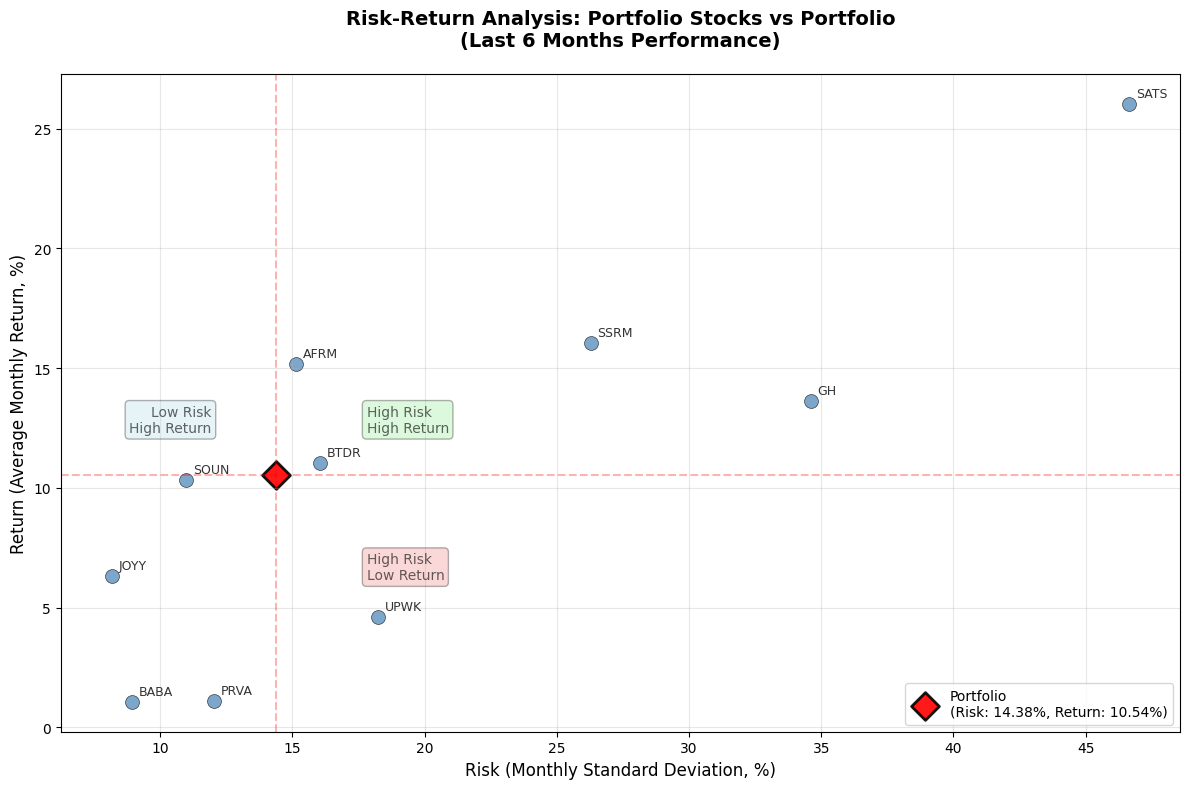


5. INDIVIDUAL STOCK RISK-RETURN SUMMARY
-------------------------------------------------------
Stock  Return (%)   Risk (%)   Risk/Return 
-------------------------------------------------------
SOUN   10.34        10.97      1.06        
GH     13.65        34.59      2.53        
SSRM   16.07        26.28      1.64        
BTDR   11.03        16.03      1.45        
AFRM   15.16        15.14      1.00        
UPWK   4.60         18.24      3.97        
PRVA   1.10         12.04      10.99       
JOYY   6.33         8.17       1.29        
SATS   26.05        46.64      1.79        
BABA   1.07         8.92       8.36        
-------------------------------------------------------
PORTFOLIO 10.54        14.38      1.36        

6. PERFORMANCE HIGHLIGHTS
------------------------------
Best performing stock:  SATS (26.05%)
Worst performing stock: BABA (1.07%)
Lowest risk stock:      JOYY (8.17%)
Highest risk stock:     SATS (46.64%)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# RISK-RETURN VISUALIZATION
print("4. RISK-RETURN ANALYSIS & VISUALIZATION")
print("="*45)

# Calculate risk (standard deviation) and return (mean) for each stock in the portfolio
individual_returns = monthly_returns_individual.mean() * 100  # Convert to percentage
individual_risks = monthly_returns_individual.std() * 100     # Convert to percentage

# Portfolio metrics
portfolio_return = monthly_returns_portfolio.mean() * 100
portfolio_risk = monthly_returns_portfolio.std() * 100

print(f"Portfolio Risk (Monthly Volatility): {portfolio_risk:.2f}%")
print(f"Portfolio Return (Average Monthly):  {portfolio_return:.2f}%")
print(f"Annualized Portfolio Return:         {portfolio_return * 12:.2f}%")
print(f"Annualized Portfolio Risk:           {portfolio_risk * np.sqrt(12):.2f}%")

# Create the risk-return scatter plot
plt.figure(figsize=(12, 8))

# Plot individual stocks
scatter = plt.scatter(individual_risks, individual_returns, 
                     alpha=0.7, s=100, c='steelblue', edgecolors='black', linewidth=0.5)

# Add stock labels
for i, stock in enumerate(portfolio_stocks):
    plt.annotate(stock, (individual_risks.iloc[i], individual_returns.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

# Plot portfolio point
plt.scatter(portfolio_risk, portfolio_return, 
           color='red', s=200, marker='D', edgecolors='black', linewidth=2, 
           label=f'Portfolio\n(Risk: {portfolio_risk:.2f}%, Return: {portfolio_return:.2f}%)', alpha=0.9)

# Add quadrant lines
plt.axhline(y=portfolio_return, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=portfolio_risk, color='red', linestyle='--', alpha=0.3)

# Formatting
plt.xlabel('Risk (Monthly Standard Deviation, %)', fontsize=12)
plt.ylabel('Return (Average Monthly Return, %)', fontsize=12)
plt.title('Risk-Return Analysis: Portfolio Stocks vs Portfolio\n(Last 6 Months Performance)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)

# Add quadrant labels
max_x, max_y = plt.xlim()[1], plt.ylim()[1]
min_x, min_y = plt.xlim()[0], plt.ylim()[0]

plt.text(portfolio_risk + (max_x - portfolio_risk)*0.1, portfolio_return + (max_y - portfolio_return)*0.1, 
         'High Risk\nHigh Return', ha='left', va='bottom', fontsize=10, alpha=0.6, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.3))

plt.text(portfolio_risk + (max_x - portfolio_risk)*0.1, portfolio_return - (portfolio_return - min_y)*0.3, 
         'High Risk\nLow Return', ha='left', va='top', fontsize=10, alpha=0.6,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.3))

plt.text(portfolio_risk - (portfolio_risk - min_x)*0.3, portfolio_return + (max_y - portfolio_return)*0.1, 
         'Low Risk\nHigh Return', ha='right', va='bottom', fontsize=10, alpha=0.6,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.3))

plt.tight_layout()
plt.show()

# Risk-Return Summary Table
print(f"\n5. INDIVIDUAL STOCK RISK-RETURN SUMMARY")
print("-"*55)
print(f"{'Stock':<6} {'Return (%)':<12} {'Risk (%)':<10} {'Risk/Return':<12}")
print("-"*55)

risk_return_data = []
for stock in portfolio_stocks:
    ret = individual_returns[stock]
    risk = individual_risks[stock]
    risk_return_ratio = risk / abs(ret) if abs(ret) > 0.01 else float('inf')
    risk_return_data.append((stock, ret, risk, risk_return_ratio))
    print(f"{stock:<6} {ret:<12.2f} {risk:<10.2f} {risk_return_ratio:<12.2f}")

print("-"*55)
print(f"{'PORTFOLIO':<6} {portfolio_return:<12.2f} {portfolio_risk:<10.2f} {portfolio_risk/abs(portfolio_return) if abs(portfolio_return) > 0.01 else float('inf'):<12.2f}")

# Best and worst performers
best_return_stock = individual_returns.idxmax()
worst_return_stock = individual_returns.idxmin()
lowest_risk_stock = individual_risks.idxmin()
highest_risk_stock = individual_risks.idxmax()

print(f"\n6. PERFORMANCE HIGHLIGHTS")
print("-"*30)
print(f"Best performing stock:  {best_return_stock} ({individual_returns[best_return_stock]:.2f}%)")
print(f"Worst performing stock: {worst_return_stock} ({individual_returns[worst_return_stock]:.2f}%)")
print(f"Lowest risk stock:      {lowest_risk_stock} ({individual_risks[lowest_risk_stock]:.2f}%)")
print(f"Highest risk stock:     {highest_risk_stock} ({individual_risks[highest_risk_stock]:.2f}%)")
